Mounted at /content/drive
Found 3677 images belonging to 5 classes.
Found 459 images belonging to 5 classes.
Found 463 images belonging to 5 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1636s 14s/step - accuracy: 0.6081 - loss: 1.1658 - val_accuracy: 0.8170 - val_loss: 0.5567 - learning_rate: 1.0000e-04
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 83s 721ms/step - accuracy: 0.8395 - loss: 0.5006 - val_accuracy: 0.8736 - val_loss: 0.4175 - learning_rate: 1.0000e-04
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 143s 731ms/step - accuracy: 0.8768 - loss: 0.4016 - val_accuracy: 0.8584 - val_loss: 0.4248 - learning_rate: 1.0000e-04
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 83s 722ms/step - accuracy: 0.8959 - loss: 0.3223 - val_accuracy: 0.8780 - val_loss: 0.3467 - learning_rate: 1.0000e-04
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 86s 745ms/step - accuracy: 0.9144 - loss: 0.2764 - val_accuracy: 0.8758 - val_loss: 0.3635 - learning_rate: 1.0000e-04
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 141s 737ms/step - accuracy: 0.9207 - loss: 0.2523 - val_accuracy: 0.8780 - val_loss: 0.3425 - learning_rate: 1.0000e-04
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 83s 

Ma trận nhầm lẫn:
[[142   3   1   1   7]
 [  1  19   0   0   1]
 [  0   0  17   2   9]
 [  3   1   2 168   3]
 [  9   2   2   1  69]]

📊 Báo cáo đánh giá mô hình:

              precision  recall  f1-score  support  accuracy
Charts             0.92    0.92      0.92    154.0      0.95
Maps               0.76    0.90      0.83     21.0      0.98
Others             0.77    0.61      0.68     28.0      0.97
Photographs        0.98    0.95      0.96    177.0      0.97
System_Model       0.78    0.83      0.80     83.0      0.93
accuracy           0.90    0.90      0.90      0.9       NaN
macro avg          0.84    0.84      0.84    463.0       NaN
weighted avg       0.90    0.90      0.90    463.0       NaN

📊 Báo cáo đã được lưu vào Google Drive!

✅ F1-score đạt tiêu chuẩn, mô hình đã được lưu!


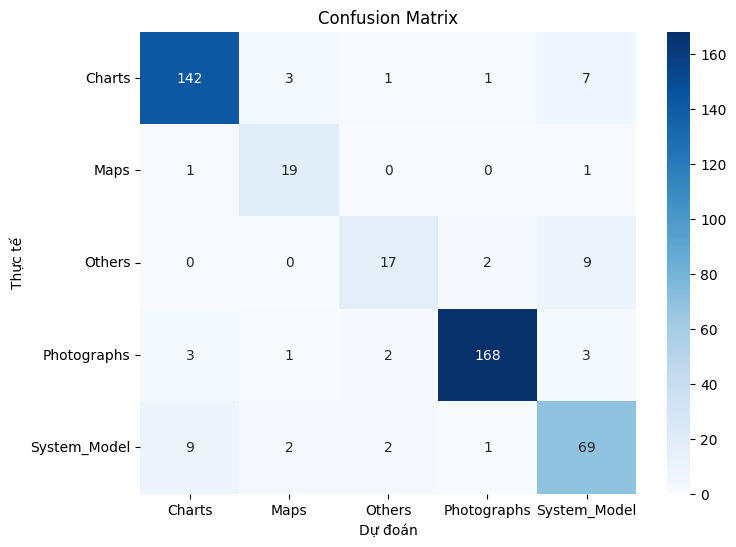

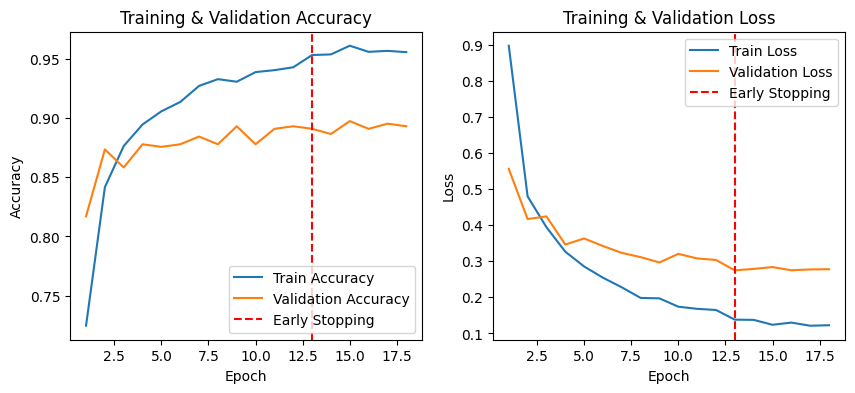

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.api.applications import ResNet50
from keras.api.applications.resnet50 import preprocess_input
from sklearn.metrics import confusion_matrix
from keras.api.models import Model
from keras.api.layers import Dense, GlobalAveragePooling2D
import math
from keras.api.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import pandas as pd
## **2. Chuẩn bị dữ liệu huấn luyện**

from keras.src.legacy.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],  # Thay đổi độ sáng trong phạm vi từ 80% đến 120%
    zoom_range=0.2  # Phóng to hoặc thu nhỏ trong phạm vi 20%
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

from google.colab import drive
drive.mount("/content/drive",force_remount=True)

train_dir = "/content/drive/My Drive/data_new/train"
val_dir = "/content/drive/My Drive/data_new/val"
test_dir = "/content/drive/My Drive/data_new/test"

train_generator = train_datagen.flow_from_directory(
    train_dir,  # Đường dẫn đến thư mục ảnh huấn luyện
    target_size=(224, 224),  # Resize ảnh
    batch_size=32,
    class_mode='categorical'  # Hoặc 'binary' nếu chỉ có 2 lớp
)


val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Không cần shuffle dữ liệu test
)


# Danh sách nhãn
samples_per_class = np.bincount(train_generator.classes)
class_labels = np.arange(len(samples_per_class))
# Charts, Maps, Others, Photograph, System_Model.

# Tính trọng số lớp
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=class_labels,
    y=train_generator.classes
)

# Chuyển về dictionary để sử dụng trong model.fit()
class_weight_dict = {i: class_weights[i] for i in range(len(class_labels))}



base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224,3))

for layer in base_model.layers:  # Freeze 100 layer đầu
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])



train_samples = train_generator.samples
val_samples = val_generator.samples
batch_size = 32
steps_per_epoch = math.ceil(train_samples / batch_size)
validation_steps = math.ceil(val_samples / batch_size)

# ## **5. Huấn luyện mô hình**


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Theo dõi val_loss thay vì loss
    factor=0.2,          # Giảm learning rate xuống 50% (thay vì 20%) để hội tụ nhanh hơn
    patience=3,          # Nếu val_loss không cải thiện sau 2 epoch, giảm LR
    min_lr=1e-6          # Giữ min_lr ở mức thấp nhưng không bằng 0
)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Theo dõi val_loss thay vì loss
    patience=5,          # Nếu val_loss không cải thiện sau 5 epoch, dừng training
    restore_best_weights=True  # Giữ lại mô hình có trọng số tốt nhất
)


history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    class_weight=class_weight_dict,
    callbacks=[reduce_lr, early_stopping]
    )  # Điều chỉnh số epoch theo nhu cầu



# Dự đoán nhãn
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Tạo báo cáo phân loại
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys(), output_dict=True)

# In bảng báo cáo đẹp hơn
df_report = pd.DataFrame(report).transpose()

cm = confusion_matrix(y_true, y_pred)
print("Ma trận nhầm lẫn:")
print(cm)

class_accuracies = {}
# Tính Accuracy cho từng lớp
for class_name, index in test_generator.class_indices.items():
    TP = cm[index, index]  # True Positive
    FN = sum(cm[index, :]) - TP  # False Negative
    FP = sum(cm[:, index]) - TP  # False Positive
    TN = np.sum(cm) - (TP + FP + FN)  # True Negative

    # Tính Accuracy
    class_accuracies[class_name] = (TP + TN) / np.sum(cm) if np.sum(cm) > 0 else 0

# Thêm cột độ chính xác vào DataFrame
df_report["accuracy"] = df_report.index.map(class_accuracies)
df_report = df_report.round(2)
print("\n📊 Báo cáo đánh giá mô hình:\n")
print(df_report)
df_report.to_csv("/content/drive/My Drive/Report/classification_report_resnet50_2.csv")
print("\n📊 Báo cáo đã được lưu vào Google Drive!")
# Lấy chỉ số F1-score trung bình
f1_avg = report["macro avg"]["f1-score"]

# Điều kiện lưu mô hình
THRESHOLD_F1 = 0.75  # Ngưỡng F1-score tối thiểu

if f1_avg > THRESHOLD_F1:
    model.save("/content/resnet50_2.h5")
    !cp /content/resnet50_2.h5 "/content/drive/My Drive/Model/resnet50_2.h5"
    print("\n✅ F1-score đạt tiêu chuẩn, mô hình đã được lưu!")
else:
    print("\n❌ F1-score chưa đạt, không lưu mô hình.")

best_epoch = early_stopping.stopped_epoch - early_stopping.patience + 1
best_epoch = max(best_epoch, 1)
# Giả sử history là kết quả từ model.fit()

# Giả sử history là kết quả từ model.fit()
import seaborn as sns
plt.figure(figsize=(8,6))
labels = list(test_generator.class_indices.keys())
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Confusion Matrix')
save_path = '/content/drive/My Drive/Report/confusion_matrix_50.png'
plt.savefig(save_path)
plt.show()

# Vẽ đồ thị Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], label='Train Accuracy')
plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], label='Validation Accuracy')
plt.axvline(best_epoch, color='r', linestyle='--', label='Early Stopping')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Vẽ đồ thị Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], label='Train Loss')
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label='Validation Loss')
plt.axvline(best_epoch, color='r', linestyle='--', label='Early Stopping')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()


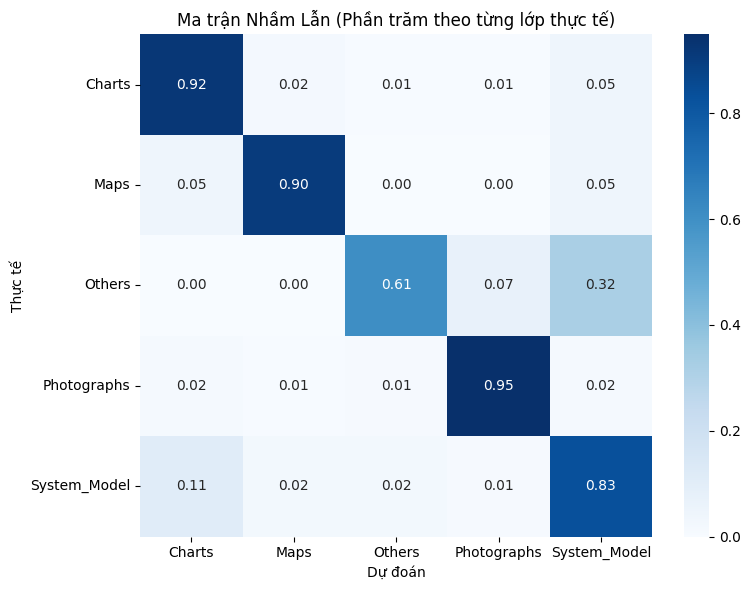

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ma trận nhầm lẫn dạng số lượng ảnh
cm = np.array([
    [142,   3,   1,   1,   7],
 [  1,  19 ,  0 ,  0   ,1],
 [  0 ,  0 , 17 ,  2  , 9],
 [  3  , 1 ,  2 ,168 ,  3],
 [  9   ,2,   2  , 1,  69]
])

# Tên lớp (nên khớp với test_generator.class_indices nếu có)
class_names = ['Charts', 'Maps', 'Others', 'Photographs', 'System_Model']

# Chuẩn hóa thành phần trăm theo từng hàng (tức là theo lớp thực tế)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Vẽ heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.title("Ma trận Nhầm Lẫn (Phần trăm theo từng lớp thực tế)")
plt.tight_layout()
plt.show()
